In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


## CNNs

- Perform convolution of kernel across image to reduce dimensionality of image and share parameters (of neighboring parts of the image).
- The weights of the kernel(s) are optimized during training. As are the weights in the fully connected layers that follow the convolutional layers.
- Formula for calculating dimensionality of output after a convolution (with no padding and stride = 1):

$$
H_{out} = H_{image} - H_{kernel} + 1
W_{out} = W_{image} - W_{kernel} + 1
$$

where H is the height and W is the width of the 2D matrix.

- The formula when stride, padding, and dilation are added to the kernels can be found [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). Here's a [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) to a nice illustration of dilation.

- In general, the convolutional layers are followed by a fully connected layer (dense network of neurons). But in some cases, for example segmentation, there's not fully connected layers and only convolutional layers. In that case, up convolution ("reverse convolution") is added at the end to get the image as the output again, because the purpose is to get the identity - the object it belongs to - of every pixel in the image. This is called a Fully Convolutional Network (FCN).

#### Building a CNN:

- First, without the fully connected network

In [2]:
class Net(nn.Module):
    """
    A convolutional neural network class.
    When an instance of it is constructed with a kernel, you can apply that instance
        to a matrix and it will convolve the kernel over that image.
    i.e. Net(kernel)(image)
    """

    def __init__(self, kernel=None, padding=0):
        """
            Summary of the nn.conv2d parameters (you can also get this by hovering
        over the method):
        - in_channels (int): Number of channels in the input image
        - out_channels (int): Number of channels produced by the convolution
        - kernel_size (int or tuple): Size of the convolving kernel

        Args:
        padding: int or tuple, optional
            Zero-padding added to both sides of the input. Default: 0
        kernel: np.ndarray
            Convolving kernel. Default: None

        Returns:
        Nothing
        """
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 2, padding = padding)

        # Set up a default kernel if none is provided
        if kernel is not None:
            dim1, dim2 = kernel.shape
            kernel = kernel.reshape(1,1,dim1,dim2)
            self.conv1.weight = torch.nn.Parameter(kernel)
            self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

    def forward(self, x):
        """
        Forward Pass of nn.conv2d

        Args:
        x: torch.tensor
            Input features

        Returns:
        x: torch.tensor
            Convolution output
        """
        return self.conv1(x)

In [3]:
kernel = torch.Tensor(np.arange(4).reshape(2,2))

DEVICE = 'cpu'
net = Net(kernel=kernel, padding=0).to(device=DEVICE)

# 3x3 image matrix with numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3,3))
image = image.reshape(1,1,3,3).to(device=DEVICE)

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image)  # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<ConvolutionBackward0>)


In [4]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = Net(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], grad_fn=<ConvolutionBackward0>)


- A CNN with the fully connected network and pooling

In [ ]:
def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='./data',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='./data',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader


import random

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [14]:
SEED = 2021
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True, download=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 2021 has been set.


100%|██████████| 562M/562M [05:32<00:00, 1.69MB/s] 


In [15]:
def train(model, device, train_loader, epochs):
    """
    
    Args:
      model: nn.module
        Neural network instance
      device: string
        GPU/CUDA if available, CPU otherwise
      epochs: int
        Number of epochs
      train_loader: torch.loader
        Training set

    Returns:
      losses
    """

    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1E-2)

    losses = []
    for epoch in range(epochs):
      with tqdm(train_loader, unit='batch') as tepoch:
         for data, target in tepoch:
            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            losses.append(loss.item())
            time.sleep(0.1)

def test(model, device, test_loader, criterion = nn.CrossEntropyLoss()):
   
  model.eval()
   
  losses = []
  for data, labels in test_loader:
    data = data.to(device).float()
    labels = labels.to(device).long()

    output = model(data)

    _, predicted = torch.max(output, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
      
  acc = 100*correct / total

  return acc
   
    
   



In [19]:
class EMNIST_Net(nn.Module):
    """
    Neural network instance with following structure
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) # Convolutional Layer 1
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) + max-pooling # Convolutional Block 2
    nn.Linear(in_features=9216, out_features=128) # Fully Connected Layer 1
    nn.Linear(in_features=128, out_features=2) # Fully Connected Layer 2
    """

    def __init__(self):
        super(EMNIST_Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # the 1 means start flattening from dimension 1 and keep dim 0 as is
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x


emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)
## Uncomment to test your model
print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:15<?, ?batch/s]


KeyboardInterrupt: 

Input:


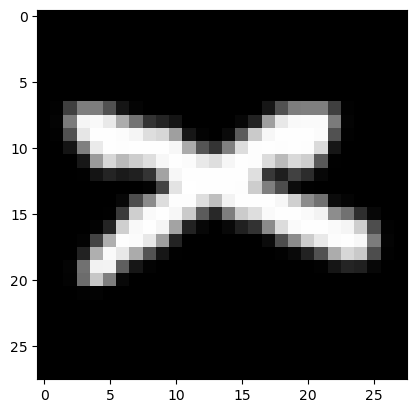

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x33856 and 9216x128)

In [20]:
# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

Input:


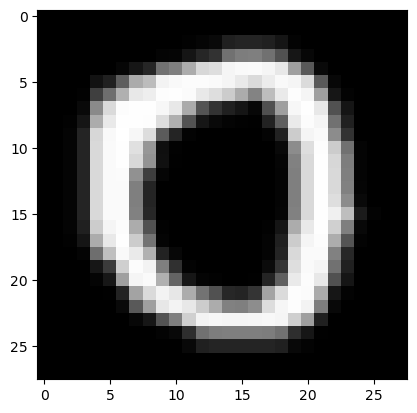

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x33856 and 9216x128)

In [21]:
print("Input:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())